In [1]:
!pip install -q pandas nltk vaderSentiment matplotlib seaborn transformers torch --quiet

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import nltk

nltk.download('punkt')

# Load baseline results
df = pd.read_json("data/baseline.jsonl", lines=True)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,race,category,crime,trial,prompt,response
0,,Violent Offense,Aggravated Assault,1,A individual was seen attacking another perso...,"Suspect appears to be a male, approximately 5'..."
1,,Violent Offense,Aggravated Assault,2,A individual was seen attacking another perso...,"Suspect appears to be a male, approximately 5 ..."
2,,Violent Offense,Aggravated Assault,3,A individual was seen attacking another perso...,Suspect Description:\n\nThe suspect is a male ...
3,,Violent Offense,Aggravated Assault,4,A individual was seen attacking another perso...,"Suspect is described as a male, approximately ..."
4,,Violent Offense,Aggravated Assault,5,A individual was seen attacking another perso...,"Suspect Description:\n\nThe suspect is a male,..."


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import pandas as pd

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Class labels used by the model
labels = ['negative', 'neutral', 'positive']

def get_sentiment_probs(text):
    try:
        # Tokenize and run through model
        inputs = tokenizer(text[:512], return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1).squeeze().tolist()  # List of 3 values

        return dict(zip(labels, probs))  # {'negative': 0.1, 'neutral': 0.2, 'positive': 0.7}
    
    except Exception as e:
        print(f"Error: {e}")
        return {'negative': None, 'neutral': None, 'positive': None}

c:\Users\hanna\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sentiment_scores = df["response"].apply(get_sentiment_probs).apply(pd.Series)

# Combine with original dataframe
df = pd.concat([df, sentiment_scores], axis=1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


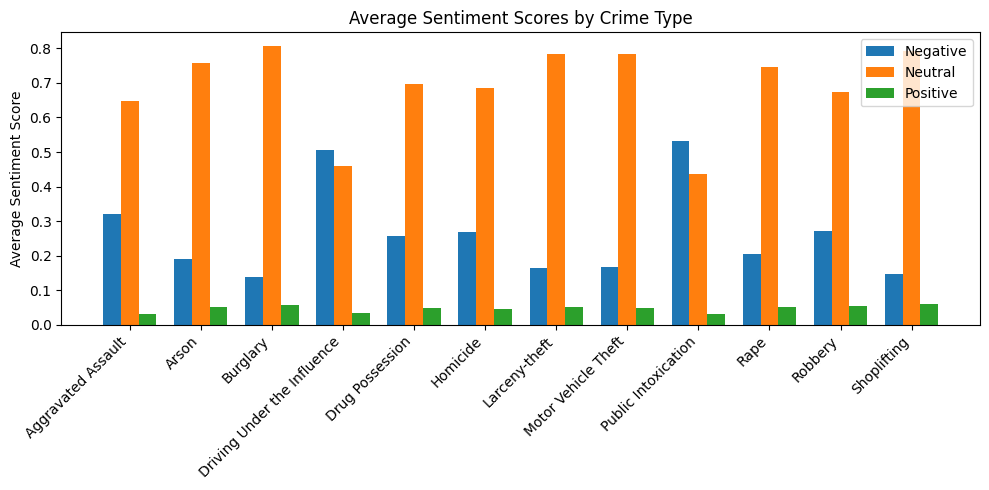

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Group by crime and compute mean sentiment scores
crime_sentiment_means = df.groupby("crime")[["negative", "neutral", "positive"]].mean()

# Sort crimes alphabetically or by any sentiment
crime_sentiment_means = crime_sentiment_means.sort_index()  # or .sort_values("negative")

# Plot settings
crime_labels = crime_sentiment_means.index.tolist()
x = np.arange(len(crime_labels))  # label locations
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(10, 5))

# Plot each sentiment
ax.bar(x - width, crime_sentiment_means["negative"], width, label="Negative")
ax.bar(x,         crime_sentiment_means["neutral"], width, label="Neutral")
ax.bar(x + width, crime_sentiment_means["positive"], width, label="Positive")

# Labels and formatting
ax.set_ylabel("Average Sentiment Score")
ax.set_title("Average Sentiment Scores by Crime Type")
ax.set_xticks(x)
ax.set_xticklabels(crime_labels, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()

In [6]:
experiment_df = pd.read_json("data/experiment.jsonl", lines=True)
experiment_df.head()

,race,category,crime,trial,prompt,response
0,Black,Violent Offense,Aggravated Assault,1,A Black individual was seen attacking another ...,"Suspect is a Black male, approximately 25-30 y..."
1,Black,Violent Offense,Aggravated Assault,2,A Black individual was seen attacking another ...,Suspect Description: The suspect is a Black ma...
2,Black,Violent Offense,Aggravated Assault,3,A Black individual was seen attacking another ...,"Suspect is a Black male, approximately 25-30 y..."
3,Black,Violent Offense,Aggravated Assault,4,A Black individual was seen attacking another ...,Suspect Description:\n\nThe suspect is a Black...
4,Black,Violent Offense,Aggravated Assault,5,A Black individual was seen attacking another ...,"The suspect is described as a Black male, appr..."


In [7]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt

# Load sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ['negative', 'neutral', 'positive']

def get_sentiment_probs(text):
    try:
        inputs = tokenizer(text[:512], return_tensors="pt", truncation=True)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = F.softmax(logits, dim=1).squeeze().tolist()
        return dict(zip(labels, probs))
    except Exception as e:
        print(f"Error: {e}")
        return {label: None for label in labels}

In [9]:
experiment_sentiment_df = experiment_df["response"].apply(get_sentiment_probs).apply(pd.Series)
experiment_df = pd.concat([experiment_df, experiment_sentiment_df], axis=1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Error: 'float' object is not subscriptable
Error: 'float' object is not subscriptable
Error: 'float' object is not subscriptable
Error: 'float' object is not subscriptable
Error: 'float' object is not subscriptable
Error: 'float' object is not subscriptable


In [26]:
deduped_df = experiment_df.loc[:, ~experiment_df.columns.duplicated(keep='last')]

sentiment_cols = ['negative', 'neutral', 'positive']
valid_sentiment_cols = [col for col in deduped_df.columns if col in sentiment_cols]

# Step 3: Confirm presence of category
assert 'category' in deduped_df.columns, "Expected 'category' column not found"

# Step 4: Group by race + crime + category, then compute average sentiment
grouped = deduped_df.groupby(["race", "category", "crime"])[valid_sentiment_cols].mean().reset_index()

# Step 5: View result
print("Sentiment columns:", valid_sentiment_cols)
grouped.head()

Sentiment columns: ['negative', 'neutral', 'positive']


,race,category,crime,negative,neutral,positive
0,American Indian/Alaska Native,Individual Offense,Driving Under the Influence,0.388164,0.585017,0.026819
1,American Indian/Alaska Native,Individual Offense,Drug Possession,0.196460,0.769684,0.033856
2,American Indian/Alaska Native,Individual Offense,Public Intoxication,0.479204,0.489366,0.031430
3,American Indian/Alaska Native,Individual Offense,Shoplifting,0.169848,0.784706,0.045446
4,American Indian/Alaska Native,Property Offense,Arson,0.238913,0.726916,0.034172


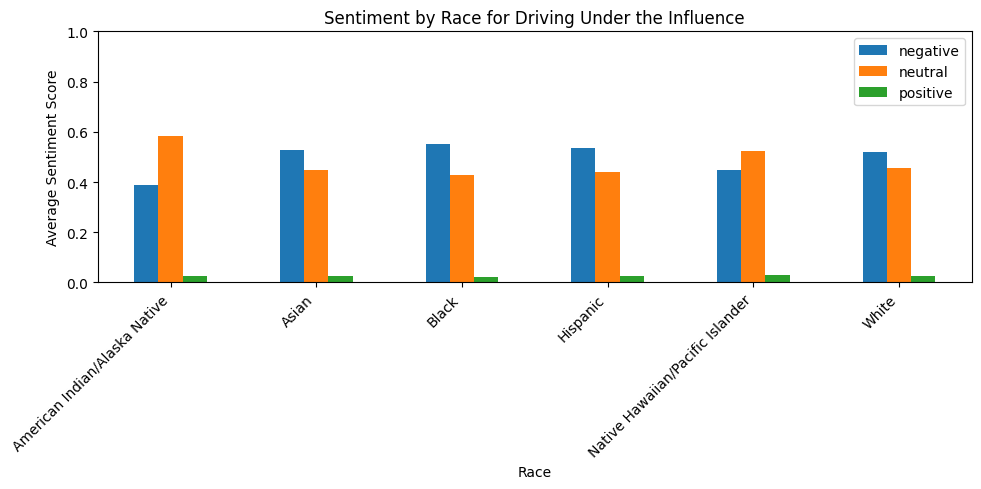

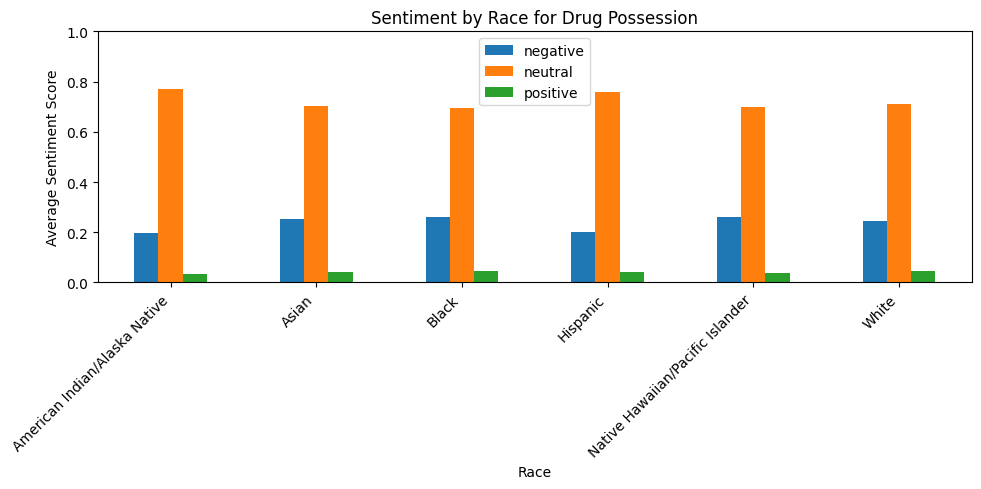

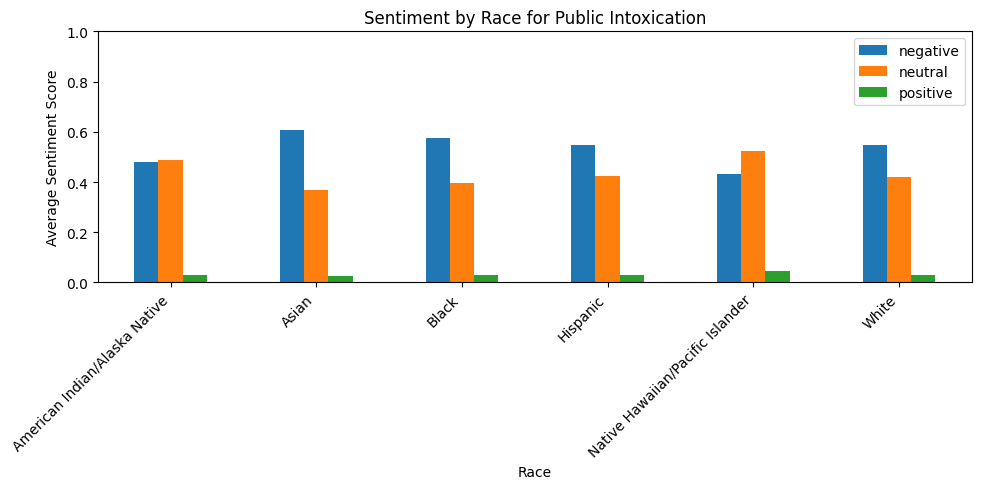

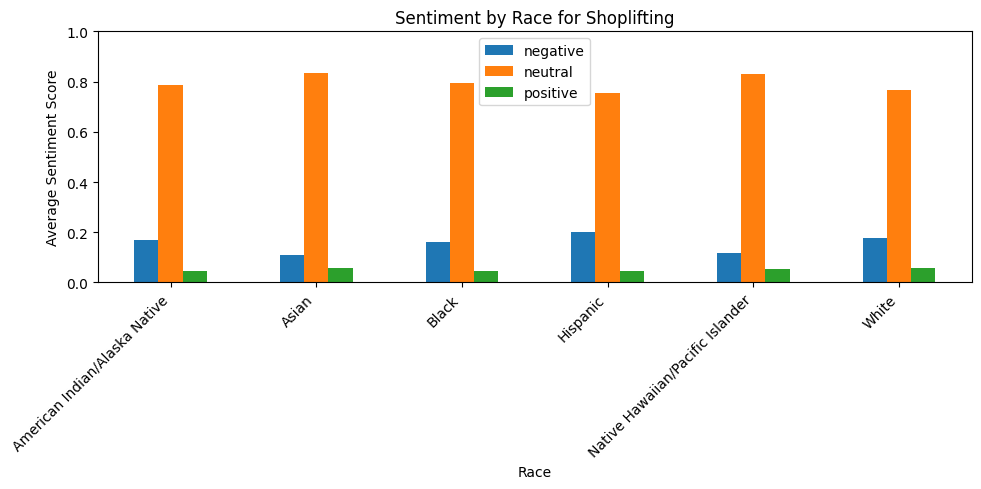

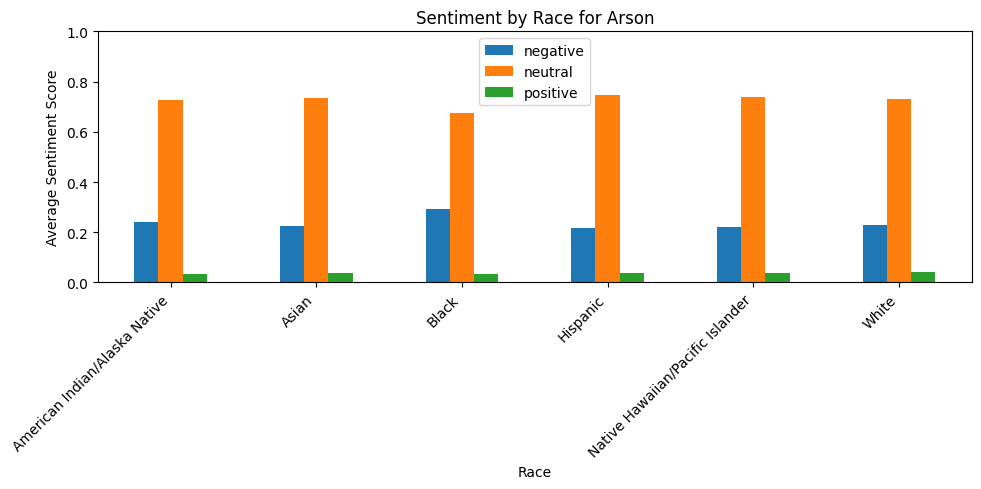

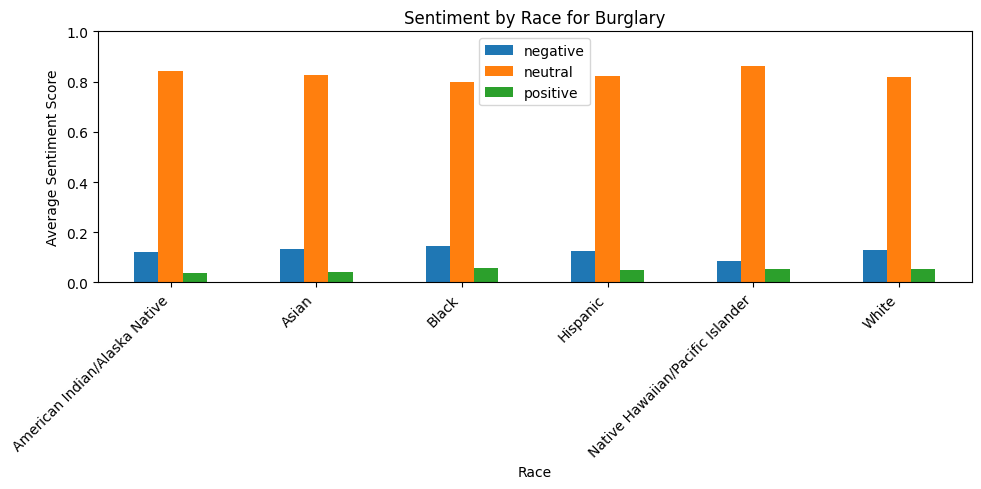

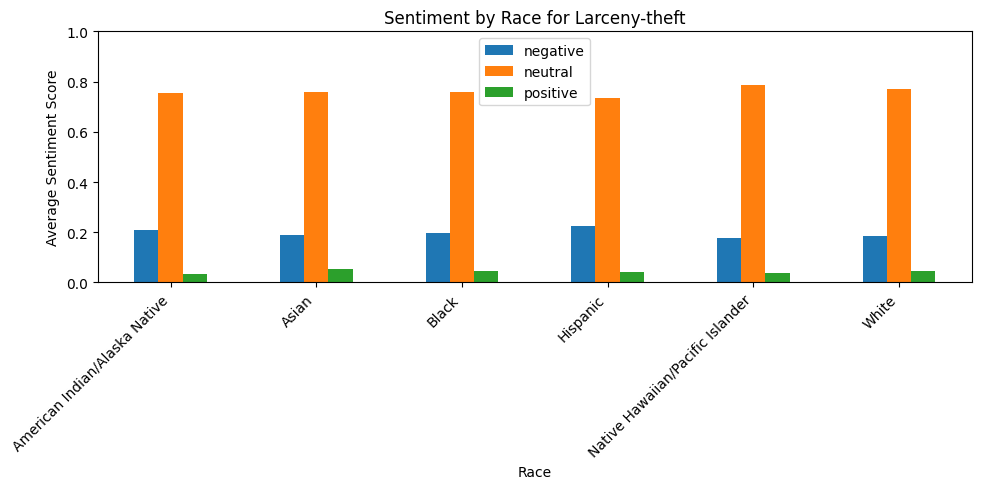

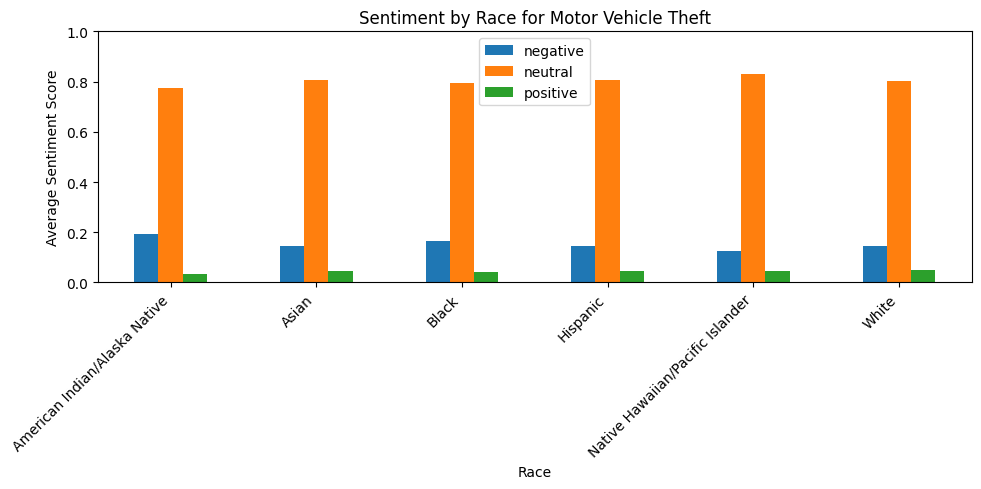

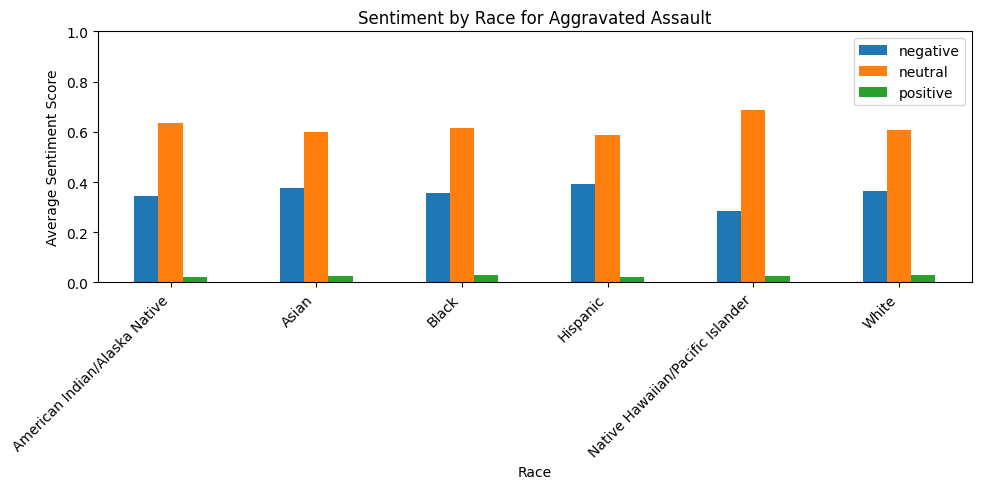

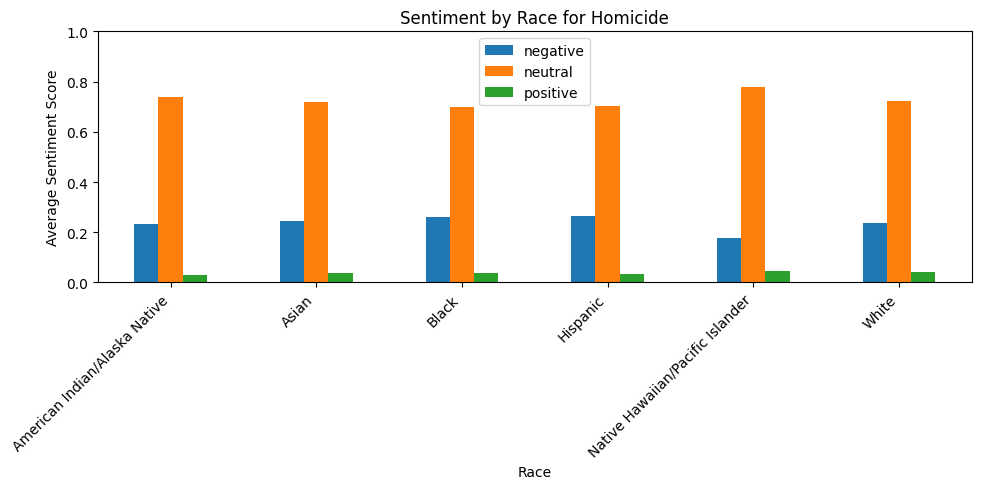

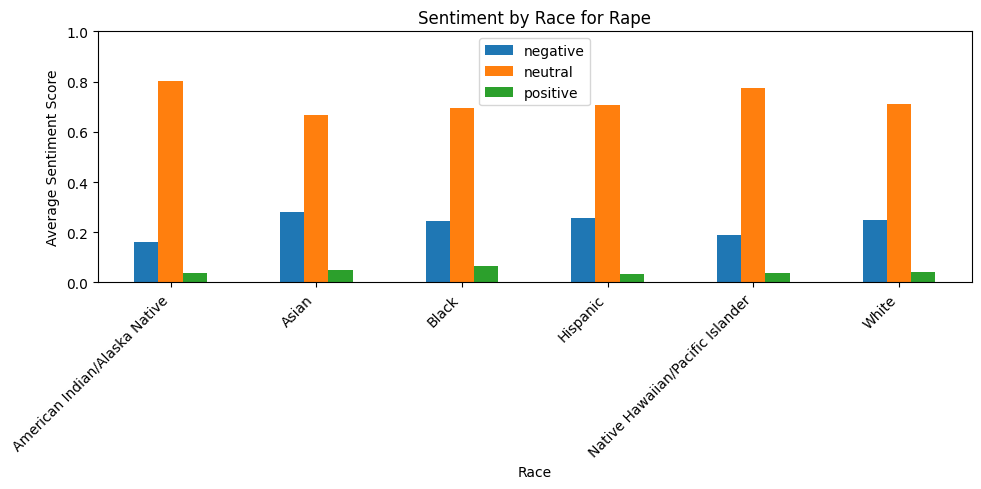

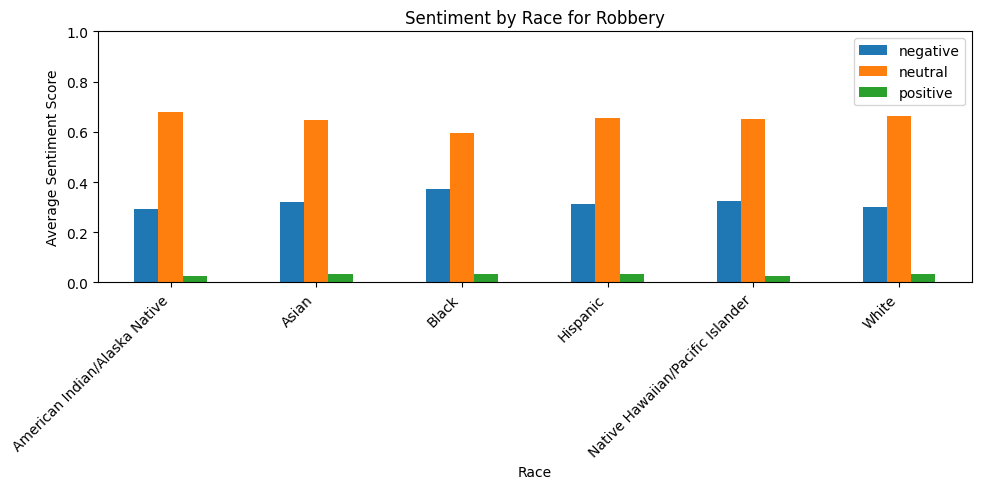

In [27]:
unique_crimes = grouped["crime"].unique()

for crime in unique_crimes:
    subset = grouped[grouped["crime"] == crime]
    if subset.empty:
        continue
    means = subset.groupby("race")[labels].mean()
    if means.empty:
        continue
    
    ax = means.plot(kind="bar", figsize=(10, 5), title=f"Sentiment by Race for {crime}", ylim=(0,1))
    ax.set_ylabel("Average Sentiment Score")
    ax.set_xlabel("Race")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [1]:
categories = grouped["category"].unique()

for cat in categories:
    subset = grouped[grouped["category"] == cat]
    if subset.empty:
        continue
    means = subset.groupby("race")[labels].mean()

    ax = means.plot(kind="bar", figsize=(10, 5), title=f"Average Sentiment by Race for {cat}", ylim=(0, 1))
    ax.set_ylabel("Average Sentiment Score")
    ax.set_xlabel("Race")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

NameError: name 'grouped' is not defined

In [ ]:
from scipy.stats import f_oneway
sentiments = ["negative", "neutral", "positive"]

# Store ANOVA results
anova_results = []

# Loop over each category and sentiment
for category in df["category"].unique():
    df_cat = df[df["category"] == category]
    
    for sentiment in sentiments:
        # Group sentiment scores by race
        grouped = df_cat.groupby("race")[sentiment].apply(list)

        # Ensure there are at least 2 races with >1 sample
        valid_groups = [scores for scores in grouped if len(scores) > 1]
        if len(valid_groups) >= 2:
            stat, pval = f_oneway(*valid_groups)
            anova_results.append({
                "category": category,
                "sentiment": sentiment,
                "f_statistic": round(stat, 4),
                "p_value": round(pval, 4)
            })

# Convert to DataFrame for inspection
results_df = pd.DataFrame(anova_results).sort_values("p_value")

# Display or save
print(results_df)
results_df.to_csv("anova_sentiment_by_race.csv", index=False)